# Генерация текста с помощью LSTM-сетей

Сеть способна выучить распределение символов в последовательностях


Датасет формируем проходясь окном по текстовому корпусу, задача сети - предсказывать следующий символ на основании нескольких предыдущих.
Данный подход можно улучшить, используя только отдельные предложения с паддингами.

In [2]:
import tensorflow as tf
import numpy as np

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Bidirectional, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.utils import to_categorical

In [5]:
import pandas as pd
from tqdm import tqdm

### 0. Получение данных для обучения

Для обучения используется датасет российских новостей, который был сохранён в файл `text_corpus.parquet` со следующими параметрами:

In [12]:
# data.to_parquet("text_corpus.parquet", engine="pyarrow", compression="gzip", index=False)

In [14]:
data = pd.read_parquet("text_corpus.parquet", engine="pyarrow")

In [15]:
data.head()

,text
0,ФСБ обнародовала оперативную видеосъемку задер...
1,Министр образования и науки Ольга Васильева сч...
2,Россия и Турция не пересматривали достигнутые ...
3,Исполнительный директор - заместитель гендирек...
4,Президент США Дональд Трамп сегодня заклеймил ...


### 1. Вспомогательные функции:
+ Визуализация процесса обучения
    + Сможем посмотреть, как меняется качество с течением времени.
+ Коллбек ModelCheckpoint
    + Процесс обучения LSTM сетей достаточно длительный. Будет обидно, если из-за непредвиденного сбоя потеряется прогресс за многие часы обучения.
+ Колбек динамической подстройки размера батча и learning rate
    + Подстраивать LR это уже стандартная практика, а я хочу ещё и размер батча менять: предположу, что большой батч позволит дать некое "обобщённое" представление о распределении символов, а маленький батч улучшит "грамотность".



In [17]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.show()

In [18]:
ModelCheckpointCb = ModelCheckpoint(
    filepath="./model2_checkpoints/", 
    monitor='val_loss', 
    verbose=0, 
    save_best_only=True,
    save_weights_only=True, 
    mode='auto', 
    save_freq='epoch',
    options=None
)

In [19]:
def scheduler(epoch, lr):
    if epoch < 30:
        return lr
    else:
        return lr * tf.math.exp(-0.1)


LearningRateSchedulerCb = LearningRateScheduler(
    scheduler, 
    verbose=0
)


In [9]:
# весь текст одной "портянкой", чтобы заранее оценить, какие символы могут нам попадаться
# raw_text = " ".join(data.text)
# chars = sorted(list(set(raw_text)))
# chars

### 3. Предобработка и создание датасета

Для тренировки LSTM модели понадобится немного поработать с форматами

#### 3.1 Входные данные char-level с паддингами

По результатам опытов показали себя не очень хорошо

In [10]:
tokenizer = Tokenizer(
    num_words=None, # не ограничиваем количество токенов
    filters='\t\xa0•…–—‘’“”«»', # отфильтровываю датасет-специфичный мусор
    lower=True,
    split=' ', 
    char_level=True, # ставим флаг посимвольного кодирования, иначе словарь слишком велик 
    oov_token="<OOV>",
)

In [37]:
# потребуется разделить тексты на предложения, которые потом будут доводиться паддингом до нужной длины
from razdel import sentenize
corpus = [text for t in data.text for text in t.split("\n")]
sentences = [sent.text for text in corpus for sent in sentenize(text)]

In [72]:
def apply_tokenizer_with_moving_window(sents):
    sequences = []
    for line in sents:
        token_list = tokenizer.texts_to_sequences(line)
        for i in range(1, len(token_list)):
            n_gram_sequence = token_list[:i+1]
            sequences.append(n_gram_sequence)
    return sequences

In [ ]:
tokenizer.fit_on_texts(corpus)
total_words = len(tokenizer.word_index) + 1
print(total_words)

In [64]:
# Сразу создам отложенную выборку для валидации
train_sentences = sentences[3000:]
test_sentences = sentences[:3000]

In [73]:
train_sequences = apply_tokenizer_with_moving_window(train_sentences)
test_sequences = apply_tokenizer_with_moving_window(test_sentences)

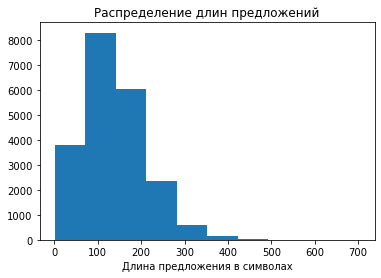

In [44]:
# Оценим длины предложений, чтобы подобрать подходящий размер последовательности
sentences_lengthes = list(map(len, sentences))

plt.hist(sentences_lengthes)
plt.title("Распределение длин предложений")
plt.xlabel("Длина предложения в символах")
plt.show()

In [54]:
# выбираем окно для паддинга
# window_length = max(sentences_lengthes)
window_length = 300 # можно выбрать меньше и обрезать
print(window_length)

300


In [74]:
# train_sequences = np.array(pad_sequences(train_sequences, maxlen=window_length, padding='pre'))
# test_sequences = np.array(pad_sequences(test_sequences, maxlen=window_length, padding='pre'))

In [76]:
# отделю последнюю колонку символов в качестве целевой переменной 
# и закондирую
X_train, y_train = train_sequences[:,:-1], to_categorical(train_sequences[:,-1], num_classes=total_words)
X_test, y_test = test_sequences[:,:-1], to_categorical(test_sequences[:,-1], num_classes=total_words)

#### 3.2 Без паддингов, скользящим окном по сплошной портянке

Также делить на train и test не буду, а поставлю параметр модели.

In [24]:
corpus = "\n".join(data.text.to_list())

In [25]:
tokenizer.fit_on_texts([corpus])
total_words = len(tokenizer.word_index) + 1
print(total_words)

65


In [12]:
window_length = 100

In [33]:
dataset = np.array(tokenizer.texts_to_sequences([corpus])[0])# получаем плоский вектор (1, количество токенов)

In [39]:
# так как я потом его хочу свернуть в строки по 100 токенов, 
# нужно, чтобы он был выравнен (отрежу от конца лишнее)
# dataset = dataset[:-(len(dataset)%window_length)]

In [34]:
len(dataset)

1134656

In [35]:
sequences = np.ndarray((len(dataset), 100))
for i in tqdm(range(len(dataset)-100)):
    sequences[i, :] = dataset[i:i+100]
dataset = sequences

100%|██████████| 1134556/1134556 [00:02<00:00, 444166.04it/s]


### 3.3 Токенизация не посимвольная, а BPE 

BPE токенизация посредством yttm эффективна, но потребуется поработать с файлом

In [34]:
import youtokentome as yttm
import re

In [47]:
total_words = 6000
max_sequence_length = 80

In [35]:
corpus = " \n".join(data.text.to_list()).lower()
# Хочу во-первых отделить всю пунктуацию от слов пробелом
corpus = " ".join(re.findall(r"[\w']+|[.,!?;\n]", corpus))

In [23]:
train_data_path = "yttm_train_data.txt"
bpe_model_path = "bpe.yttm"

In [36]:
with open(train_data_path, "w") as _file:
    _file.writelines(corpus)

In [37]:
# Training model
# (data, model, vocab_size, coverage, n_threads=-1, pad_id=0, unk_id=1, bos_id=2, eos_id=3)
bpe = yttm.BPE.train(data=train_data_path, vocab_size=total_words, model=bpe_model_path)

In [38]:
# Loading model
bpe = yttm.BPE(model=bpe_model_path)

In [39]:
print(' '.join(bpe.vocab())[:300])

<PAD> <UNK> <BOS> <EOS> ▁ о е и а н т с р в л к п д м у я ы г з б , ь ч й . х ж ' ц ю ш ф щ э ъ ? ё ! ; _ ▁п ▁с ▁в ▁, ст ни ра ро но ре на ▁о ко то ▁. ▁и ▁по го не де те ли ва ▁м за ны ▁на ль ка ри та ле ла ▁д во ве ▁б ти ци ▁со ви ▁ч ки ло ▁у ▁за ▁' да ть ен ми ▁а ▁не ▁ко сс ▁пре ет ру ся ди ▁про н


In [102]:
# encode(self, 
#     sentences, 
#     output_type=yttm.OutputType.ID, 
#     bos=False, 
#     eos=False, 
#     reverse=False, 
#     dropout_prob=0)

In [ ]:
# from razdel import sentenize
# corpus = [text for t in data.text for text in t.split("\n")]
# sentences = [sent.text for text in corpus for sent in sentenize(text)]

False

In [48]:
# dataset = np.ndarray((len(sentences), max_sequence_length))
sequence = np.array(bpe.encode(corpus))
# for idx, sent in enumerate(sentences):
#     line = bpe.encode(sent)
#     sequences.append(line)
# dataset = pad_sequences(sequences, maxlen=max_sequence_length, padding='post', value=0)
sequences = sequence[:-(len(sequence)%max_sequence_length)].reshape((len(sequence)//max_sequence_length, max_sequence_length))

In [49]:
sequences.shape

(116736, 80)

In [58]:
type(list(sequences[0,:])[0])

numpy.int64

In [60]:
bpe.decode([list(sequences[1,:])])

['это триперекись ацетона , очень опасное инициирующее взрывчатое вещество , поясняет сотрудник на видео . в военных целях обнаруженное вещество не применяется из за высокой летучести и чувствительности к ударам , нагреванию и другим внешним воздействиям . процесс создания взрывных устройств на основе данного вещества']

In [105]:
# dataset = dataset.astype(np.float32)

------------------
Собираем данные в нужные структуры

In [106]:
# dataset = dataset.reshape(((len(dataset)//window_length), window_length))

In [36]:
X, y = dataset[:,:-1], to_categorical(dataset[:,-1], num_classes=total_words)

In [37]:
X = X.reshape((*X.shape, 1))

In [38]:
X.shape


(1134656, 99, 1)

In [39]:
y.shape

(1134656, 65)

## 4. Модель

В качестве модели будет применяться LSTM сеть с двумя слоями LSTM

In [ ]:
model = Sequential()
model.add(LSTM(128, input_shape=(X.shape[1], X.shape[2]), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(128))
model.add(Dropout(0.2))
model.add(Dense(y.shape[1], activation='softmax'))

In [50]:
model.compile(
    loss='categorical_crossentropy', 
    optimizer='adam', 
    metrics=['accuracy']
)

In [52]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 99, 256)           264192    
_________________________________________________________________
dropout_2 (Dropout)          (None, 99, 256)           0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 256)               525312    
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 65)                16705     
Total params: 806,209
Trainable params: 806,209
Non-trainable params: 0
_________________________________________________________________


In [53]:
history = model.fit(X, y, 
    epochs=1, 
    verbose=1,
    callbacks=[ModelCheckpointCb],
    batch_size=500, 
    validation_split=0.3, 
#     validation_data=(X_test, y_test), 
    shuffle=False, 
#     class_weight=None,
#     sample_weight=None, 
#     initial_epoch=0, 
#     steps_per_epoch=None,
#     validation_steps=None, 
#     validation_batch_size=None, 
#     validation_freq=1,
#     max_queue_size=10, 
#     workers=1, 
#     use_multiprocessing=False
)

 734/1589 [============>.................] - ETA: 29:08 - loss: 3.0341 - accuracy: 0.1548

KeyboardInterrupt: 

In [40]:
model2 = Sequential()
model2.add(LSTM(64))
model2.add(Dropout(0.1))
model2.add(Dense(y.shape[1], activation='softmax'))

In [41]:
model2.compile(
    loss='categorical_crossentropy', 
    optimizer='adam', 
    metrics=['accuracy']
)

In [43]:
history = model2.fit(X, y, 
    epochs=30, 
    verbose=1,
    callbacks=[ModelCheckpointCb, LearningRateSchedulerCb],
    batch_size=None, 
    validation_split=0.3, 
#     validation_data=(X_test, y_test), 
    shuffle=True, 
#     class_weight=None,
#     sample_weight=None, 
#     initial_epoch=0, 
#     steps_per_epoch=None,
#     validation_steps=None, 
#     validation_batch_size=None, 
#     validation_freq=1,
#     max_queue_size=10, 
#     workers=1, 
#     use_multiprocessing=False
)

Epoch 1/30
24821/24821 [==============================] - 704s 28ms/step - loss: 2.6530 - accuracy: 0.2338 - val_loss: 2.4983 - val_accuracy: 0.2848
Epoch 2/30
24821/24821 [==============================] - 699s 28ms/step - loss: 2.4902 - accuracy: 0.2838 - val_loss: 2.3918 - val_accuracy: 0.3127
Epoch 3/30
24821/24821 [==============================] - 707s 28ms/step - loss: 2.4097 - accuracy: 0.3093 - val_loss: 2.3120 - val_accuracy: 0.3353
Epoch 4/30
24821/24821 [==============================] - 732s 29ms/step - loss: 2.3587 - accuracy: 0.3247 - val_loss: 2.2705 - val_accuracy: 0.3507
Epoch 5/30
24821/24821 [==============================] - 721s 29ms/step - loss: 2.3242 - accuracy: 0.3359 - val_loss: 2.2409 - val_accuracy: 0.3605
Epoch 6/30
24821/24821 [==============================] - 726s 29ms/step - loss: 2.2996 - accuracy: 0.3431 - val_loss: 2.2181 - val_accuracy: 0.3689
Epoch 7/30
24821/24821 [==============================] - 736s 30ms/step - loss: 2.2805 - accuracy: 0.3484

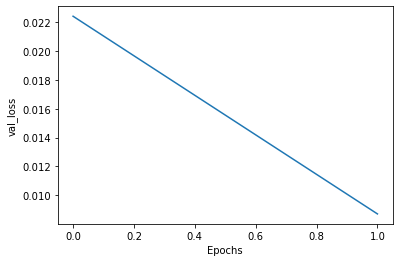

In [114]:
plot_graphs(history, 'val_loss')

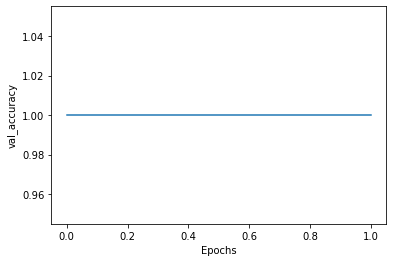

In [115]:
plot_graphs(history, 'val_accuracy')

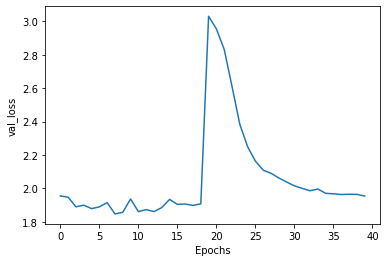

In [198]:
plot_graphs(history, 'val_loss')

In [201]:
model2.save('lstm1layer_model')

INFO:tensorflow:Assets written to: lstm1layer_model/assets


INFO:tensorflow:Assets written to: lstm1layer_model/assets


## 5. Инференс полученной модели

In [102]:
# Для обычного токенайзера
composition = "приветствие затянулось на несколько "
next_words = 200
  
for _ in range(next_words):
    token_list = tokenizer.texts_to_sequences([composition])[0]
    token_list = pad_sequences([token_list], maxlen=window_length-1, padding='pre')
    token_list = token_list.reshape((1,window_length-1,1))
    predicted = np.argmax(model.predict(token_list), axis=-1)
    output_character = tokenizer.sequences_to_texts([predicted])[0]
    composition += output_character
print(composition)

приветствие затянулось на несколько вродители,
им зае призиденторта согорами в сосесуми рроведе с сосрийской ке просева об пнобо с общела он вобороднтое влодедать в инсотия чесьдае в сосрий сазорунотти в соссий сакали проведа пода саков


In [120]:
output_character

['<PAD>']

In [122]:
# Для bpe
composition = "<BOS>приветствие затянулось на несколько "
next_words = 200
  
for _ in range(next_words):
    token_list = [2] + bpe.encode(composition)
    token_list = pad_sequences([token_list], maxlen=max_sequence_length-1, padding='post')
    token_list = token_list.reshape((1,max_sequence_length-1,1))
    predicted = np.argmax(model2.predict(token_list), axis=-1)
    output_character = bpe.decode([predicted])[0]
    composition += output_character
print(composition)

<BOS>приветствие затянулось на несколько <PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD

In [44]:
import random

In [45]:
def return_ordered_indices(ar):
    d = {i:v for i,v in enumerate(ar)}
    return sorted(d, key=d.get, reverse=True)

In [46]:
# ensures always sums to 1
def normalize_softmax(ar):
    s = sum(ar)
    if (s!=1):
        ar[0] += 1-s
    return ar
        

In [47]:
composition = "как было сказано "
next_words = 200
T = 2 # токены из top-T будут случайно выбираться
temperature = 1 # параметр сглаживания распределения выбранных токенов
  
for _ in range(next_words):
    token_list = tokenizer.texts_to_sequences([composition])[0]
    token_list = pad_sequences([token_list], maxlen=window_length-1, padding='pre')
    token_list = token_list.reshape((1,window_length-1,1))
    
    output = model2.predict(token_list)
    topmost_indicies = return_ordered_indices(output[0, :])[:T]
    probs = tf.nn.softmax(output[0, topmost_indicies] /  temperature).numpy()
    probs = normalize_softmax(probs)
    predicted = np.random.choice(topmost_indicies, p=probs)
#     predicted = topmost_indicies[0]
    output_character = tokenizer.sequences_to_texts([[predicted]])[0]
    composition += output_character
print(composition)

как было сказано осенее с онкет пантоти и ресетиеее ес о осессон в паттеле онти портовония сакомо презедлитеви презисселе нерари соргорам сосриий,
подономо по накраветения подоваи полодать по накогния сообщал возении,
